In [1]:
################### Main text ################
import numpy as np
import sys
import glob
root = glob.glob('/home/jiayun/git/workspace/data/trajectories/*')
path = ['/home/jiayun/git/workspace/data/test_trajectory/traj17_z.panda.dat']
sys.path.append('/home/jiayun/Desktop/oa-workspace/Exercises/')
from sigmoid_activation import activation
from sklearn.preprocessing import PolynomialFeatures
from regression_utils import read_residual_data
import matplotlib.pyplot as plt
from regression import BoostRegressor, CV_RR

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', **{'size': 18})
plt.rcParams.update({
  "text.usetex": True
})

In [2]:
def feature(x):
    aug = x
#     for k in range(1,2):
#         aug = np.concatenate([aug, activation(x, [7, 7.5*k, 0.01])], axis=1)
    poly = PolynomialFeatures(1)
    aug = poly.fit_transform(aug)
    return aug

def feature_tri(x):
        aug = x
        for k in range(1,7):
            aug = np.concatenate([aug, np.sin(x)], axis=1)
            aug = np.concatenate([aug, np.cos(x)], axis=1)
        poly = PolynomialFeatures(1)
        aug = poly.fit_transform(aug)
        return aug
    
def feature_tri_25(X):
    aug = X
    for k in range(1,26):
        aug = np.concatenate([aug, np.sin(k * np.pi * X)], axis=1)
        aug = np.concatenate([aug, np.cos(k * np.pi * X)], axis=1)
    poly = PolynomialFeatures(1)
    X = poly.fit_transform(aug)
    return X

In [3]:
horizon = 1
joint = 1

In [4]:
x, xref, xH, xHref, error, errorH, UG_error = read_residual_data(root, horizon, return_UG_error=True) # uGerror = U_G - tau_MCG

In [5]:
x_test, xref_test, xH_test, xHref_test, error_test, errorH_test, UG_error_test = read_residual_data(path, horizon, return_UG_error=True)

In [6]:
x = x[:, :14]
xref = xref[:, :14]
xH = xH[:, :14]
xHref = xHref[:, :14]

x_test = x_test[:, :14]
xref_test = xref_test[:, :14]
xH_test = xH_test[:, :14]
xHref_test = xHref_test[:, :14]

In [7]:
BR = BoostRegressor(1)
BR.varphi = [-4.2915028, 24.45507079, 1e-4]
BR.fit(feature(xH-xHref), errorH[:,joint:joint+1])

depth 0: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


In [8]:
pred = BR.predict(feature(xH_test - xHref_test))
MAE = np.abs(pred.reshape(-1,1) - errorH_test[:,joint].reshape(-1,1)).sum() / len(pred)
print('Test error: ', MAE)

Test error:  0.3287249182879136


In [9]:
labd = np.logspace(-2,7,10)
RR = [CV_RR(labd) for _ in range(3)]

In [10]:
for i in range(3):
    RR[i].fit(feature_tri(xH), errorH[:,4+i:4+1+i], 4, verbose=False)

100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


In [11]:
pred_RR = []
for i in range(3):
    pred_RR_i = RR[i].predict(feature_tri(xH_test), RR[i].beta).reshape(-1,1)
    pred_RR.append(pred_RR_i)
pred_RR = np.concatenate(pred_RR, axis=1)
MAE = np.abs(pred_RR.reshape(-1,3) - errorH_test[:,4:].reshape(-1,3)).sum() / len(pred_RR)
print('Test error: ', MAE)

Test error:  0.4702401499509621


# start NN compensation

In [12]:
from torch import nn
import torch
from torch import optim
import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
x.shape

(220497, 14)

In [14]:
decoupling_beta = np.loadtxt('Regression_weight/Tri_feature_decoupling.txt')

fric_pred = []
for i in range(7):
    x_i = np.concatenate([x[:, i:i+1], x[:, 7+i:i+8]], axis=1)
    fric_pred_i = feature_tri_25(x_i)@decoupling_beta[:, i:i+1]
    fric_pred.append(fric_pred_i)
    
fric_pred = np.concatenate(fric_pred, axis=1)
error_toUG = UG_error - fric_pred

In [15]:
ex = np.concatenate([x-xref, x], axis=1)
ex_test = np.concatenate([x_test-xref_test, x_test], axis=1)

In [16]:
def setParams(network:torch.nn.Module, decay:float) -> list:
    ''' function to set weight decay
    '''
    params_dict = dict(network.named_parameters())
    params=[]
    weights=[]

    for key, value in params_dict.items():
        if key[-4:] == 'bias':
            params += [{'params':value,'weight_decay':0.0}]
        else:             
            params +=  [{'params': value,'weight_decay':decay}]
    return params

In [26]:
class MLP(nn.Module):
    def __init__(self, input_d, output_d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_d, 28),
            nn.ReLU(),
            nn.Linear(28, 14),
            nn.ReLU(),
            nn.Linear(14, output_d)
        )
    def forward(self,x):
        return self.net(x)
    
net = MLP(14, 4).to(device)
optimizer = optim.Adam(setParams(net, 1e-3), lr=3e-4)

In [27]:
batch_s = 100
batch_idx = np.arange(len(x))
Loss = nn.MSELoss()
pbar = tqdm.tqdm(range(15000))
L_t = 0
vali_l = []
for count in pbar:
    optimizer.zero_grad()
    idx = np.random.choice(batch_idx, batch_s)
    x_b = torch.from_numpy(x[idx]).float().to(device)
    picked_label = error[idx]
    picked_label = picked_label[:, :4]
    y_b = torch.from_numpy(picked_label).float().to(device)
    p = net(x_b)
    L = Loss(p, y_b)
    L.backward()
    L_t += L.item()
    optimizer.step()
    if count % 500 == 0:
        input_x = torch.from_numpy(x_test).float().to(device)
        pred_nn = net(input_x).detach().cpu().numpy()
        pred_nn = pred_nn.reshape(-1,4)
        MAE = np.abs(pred_nn - error_test[:,:4].reshape(-1,4)).sum() / len(pred_nn)
        pbar.set_description('Loss: %.3f, Vali: %.3f' % (L_t/100, MAE))
        vali_l.append(MAE)
        L_t = 0

Loss: 0.097, Vali: 0.851: 100%|██████████| 15000/15000 [00:23<00:00, 650.47it/s]


In [28]:
net_last3 = MLP(14, 3).to(device)
optimizer = optim.Adam(setParams(net_last3, 1e-6), lr=3e-4)

In [29]:
batch_s = 100
batch_idx = np.arange(len(x))
Loss = nn.MSELoss()
pbar = tqdm.tqdm(range(15000))
L_t = 0
vali_l = []
e = x-xref
e_test = x_test-xref_test
for count in pbar:
    optimizer.zero_grad()
    idx = np.random.choice(batch_idx, batch_s)
    x_b = torch.from_numpy(e[idx]).float().to(device)
    picked_label = error[idx]
    picked_label = picked_label[:, 4:]
    y_b = torch.from_numpy(picked_label).float().to(device)
    p = net_last3(x_b)
    L = Loss(p, y_b)
    L.backward()
    L_t += L.item()
    optimizer.step()
    if count % 500 == 0:
        input_x = torch.from_numpy(e_test).float().to(device)
        pred_nn_last3 = net_last3(input_x).detach().cpu().numpy()
        pred_nn_last3 = pred_nn_last3.reshape(-1,3)
        MAE = np.abs(pred_nn_last3 - error_test[:,4:].reshape(-1,3)).sum() / len(pred_nn_last3)
        pbar.set_description('Loss: %.3f, Vali: %.3f' % (L_t/100, MAE))
        vali_l.append(MAE)
        L_t = 0

Loss: 0.035, Vali: 0.328: 100%|██████████| 15000/15000 [00:23<00:00, 645.99it/s]


In [30]:
pred_res = np.concatenate([pred_nn, pred_nn_last3], axis=1)

### Update 4.13 the fit of ridge regression and prediction of sigmoidal

100%|██████████| 10/10 [00:00<00:00, 15.39it/s]


Min MSE:  0.1697380485543568


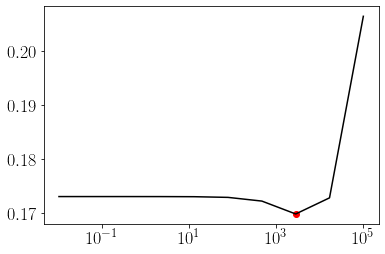

100%|██████████| 10/10 [00:00<00:00, 14.35it/s]


Min MSE:  0.03349248414075504


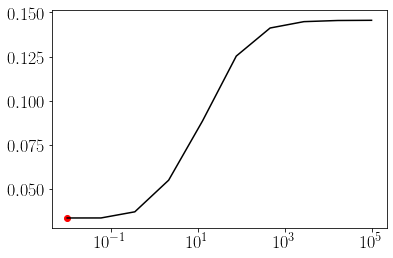

In [32]:
labd = np.logspace(-2,5,10)
RR_first_4 = CV_RR(labd=labd)
RR_last_3 = CV_RR(labd=labd)
RR_first_4.fit(feature(x), error[:,:4], 4)
RR_last_3.fit(feature(e), error[:,4:], 4)

In [33]:
RR_pred_first_4 = RR_first_4.predict(feature(x_test), RR_first_4.beta)
RR_pred_last_3 = RR_last_3.predict(feature(e_test), RR_last_3.beta)
RR_pred = np.concatenate([RR_pred_first_4, RR_pred_last_3], axis=1)

In [40]:
# sigmoidal
def friction(x, speed):
    phi1j, phi2j, phi3j = x
    tau = phi1j/(1+np.exp(-phi2j*(speed+phi3j))) - phi1j/(1+np.exp(-phi2j*phi3j))
    return tau

sigmoidal_param = np.load("../Common/residual_dynamics.npy")
pred_res_sig = []
for test_x_i in x_test[:, :7]:
    joint_fric = []
    for joint in range(7):
        pred_res_sig_i = friction(sigmoidal_param[joint], test_x_i[joint])
        joint_fric.append(pred_res_sig_i)
    joint_fric = np.array(joint_fric)
    pred_res_sig.append(joint_fric.reshape(1,-1))

/home/jiayun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [41]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sigmoidal_param

array([[0.514, 21.157, -0.013],
       [0.410, 44.743, 0.056],
       [0.546, 15.108, -0.057],
       [0.615, 948.338, -0.009],
       [0.440, 89.393, 0.000],
       [0.475, 1.838, -0.647],
       [0.470, 57.723, -0.001]])

In [42]:
pred_res_sig = np.concatenate(pred_res_sig)

In [43]:
print(((error_test)**2).sum() / len(RR_pred))
print(((RR_pred - error_test)**2).sum() / len(RR_pred))
print(((pred_res - error_test)**2).sum() / len(pred_res))
print(((pred_res_sig - error_test)**2).sum() / len(pred_res))

0.8344277189730179
0.4141607897251171
0.3557774203348011
1.009416059396194


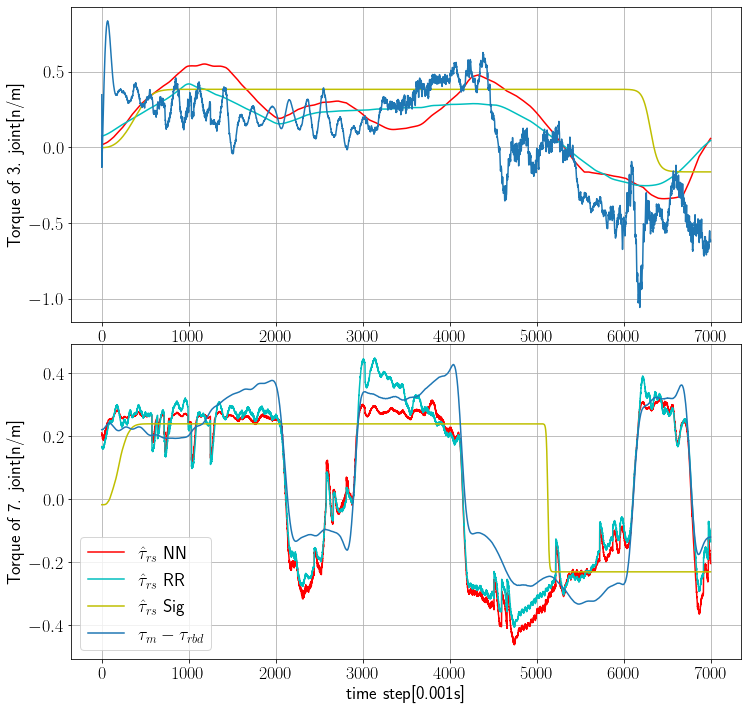

In [45]:
plt.figure(figsize=[12,12])

# for channel in range(7):
#     plt.subplot(4,2,channel+1,xlabel="time[s]", ylabel="Torque of {}. joint[n/m]".format(channel+1))
#     plt.plot(pred_res[:7000, channel], '-r', label=r"$\hat{\tau}_{rs}$ NN")
#     plt.plot(RR_pred[:7000, channel], '-c', label=r"$\hat{\tau}_{rs}$ RR")
#     plt.plot(pred_res_sig[:7000, channel], '-y', label=r"$\hat{\tau}_{rs}$ Sig")
#     plt.plot(error_test[:7000,channel].reshape(-1,1), linewidth=0.7)
#     plt.grid()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.4)
# plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
# plt.savefig("/home/jiayun/Desktop/RE_evaluation.jpg", dpi=200)
# plt.show()

plt.subplot(2, 1, 1, xlabel="time step[0.001s]", ylabel="Torque of {}. joint[n/m]".format(3))
plt.plot(pred_res[:7000, 2], '-r', label=r"$\hat{\tau}_{rs}$ NN")
plt.plot(RR_pred[:7000, 2], '-c', label=r"$\hat{\tau}_{rs}$ RR")
plt.plot(pred_res_sig[:7000, 2], '-y', label=r"$\hat{\tau}_{rs}$ Sig")
plt.plot(error_test[:7000,2].reshape(-1,1), label=r"$\tau_m - \tau_{rbd}$")
plt.grid()
plt.subplot(2, 1, 2, xlabel="time step[0.001s]", ylabel="Torque of {}. joint[n/m]".format(7))
plt.plot(pred_res[:7000, 6], '-r', label=r"$\hat{\tau}_{rs}$ NN")
plt.plot(RR_pred[:7000, 6], '-c', label=r"$\hat{\tau}_{rs}$ RR")
plt.plot(pred_res_sig[:7000, 6], '-y', label=r"$\hat{\tau}_{rs}$ Sig")
plt.plot(error_test[:7000,6].reshape(-1,1), label=r"$\tau_m - \tau_{rbd}$")
plt.grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.07)
plt.legend(fancybox=True)
plt.savefig("/home/jiayun/Desktop/RE_evaluation.jpg", dpi=200)
plt.show()

In [53]:
# save model
beta = [RR[0].beta, RR[1].beta, RR[2].beta]
beta = np.concatenate(beta, axis=1)
print(beta.shape)
np.savetxt('Regression_weight/last_3_joint_RR.txt', beta)

TypeError: 'CV_RR' object does not support indexing

In [24]:
for name, param in net.named_parameters():
    np.savetxt('Regression_weight/{}.txt'.format(name), param.detach().cpu().numpy())

In [25]:
for name, param in net_last3.named_parameters():
    np.savetxt('Regression_weight/{}_{}.txt'.format('last3', name), param.detach().cpu().numpy())

# Genetic activation

In [ ]:
import pygad

In [ ]:
def fitness_function(solution, solution_idx):
    MAE = solution ** 2 + 1
    return -MAE[0]

In [ ]:
last_fitness = 0
def callback_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))
    last_fitness = ga_instance.best_solution()[1]

In [ ]:
num_generations = 100
num_parents_mating = 8
sol_per_pop = 8
num_genes = 1
init_range_low = -50
init_range_high = 50
parent_selection_type = "sss"
keep_parents = 1
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 25

In [ ]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=callback_generation)

In [ ]:
ga_instance.run()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))